In [1]:
from pathlib import Path
import numpy as np
import pandas as pd

from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
from sklearn.preprocessing import MinMaxScaler as MMS
from sklearn.preprocessing import RobustScaler as RS
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import GRU, Dense, Flatten
from tensorflow.keras.losses import BinaryCrossentropy, MeanSquaredError, MeanAbsoluteError
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import AUC
from keras.models import load_model
import matplotlib.pyplot as plt
import seaborn as sns
import keras
import sys
sys.path.append('../')
from data_dir import LOSS_DIR, MODELS_PATH_dic
from matplotlib.ticker import FuncFormatter

D:\anaconda\lib\site-packages\scipy\__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.3
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


# Loss function 

In [2]:
name = 'First_d_CTGAN_LSTM_V6.5'  #['CTGAN_MA', 'ctg','CTGAN_F']

E_loss

In [3]:
e_loss = pd.read_csv(f'D:\\CTS_GAN\\loss/step_e_loss_t0_{name}.csv')

In [4]:
e_loss.columns = ['step', 'loss']
e_loss['step'] = e_loss.index*10

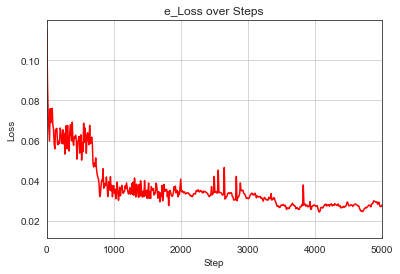

In [53]:
plt.plot(e_loss['step'], e_loss['loss'], color = 'red')
plt.xlabel('Step')
plt.ylabel('Loss')
plt.title('e_Loss over Steps')
plt.grid(True)
plt.xlim(0, 5000)
plt.show()

S_loss

In [6]:
s_loss = pd.read_csv(f'D:\\CTS_GAN\\loss/step_g_loss_s_{name}.csv')

In [7]:
s_loss.columns = ['step', 'loss']
s_loss['step'] = s_loss.index*10

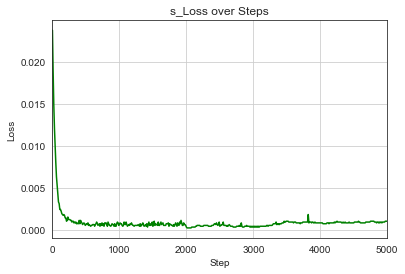

In [51]:
plt.plot(s_loss['step'], s_loss['loss'], color ='green')
plt.xlabel('Step')
plt.ylabel('Loss')
plt.title('s_Loss over Steps')
plt.grid(True)
plt.xlim(0, 5000)
plt.show()

G_loss and D_loss

In [9]:
g_loss = pd.read_csv(f'D:\\CTS_GAN\\loss/g_loss_u_{name}.csv')
d_loss = pd.read_csv(f'D:\\CTS_GAN\\loss/d_loss_{name}.csv')

In [10]:
d_loss.columns = ['step', 'loss']
d_loss['step'] = d_loss.index*10
g_loss.columns = ['step', 'loss']
g_loss['step'] = g_loss.index*10

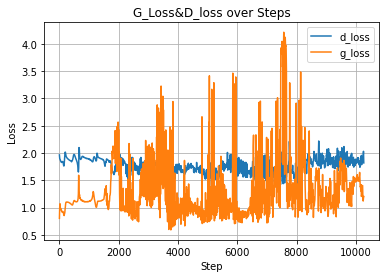

In [11]:
plt.plot(d_loss['step'], d_loss['loss'], label='d_loss')
plt.plot(g_loss['step'], g_loss['loss'], label='g_loss')
plt.xlabel('Step')
plt.ylabel('Loss')
plt.title('G_Loss&D_loss over Steps')
plt.legend()
plt.grid(True)
plt.show()

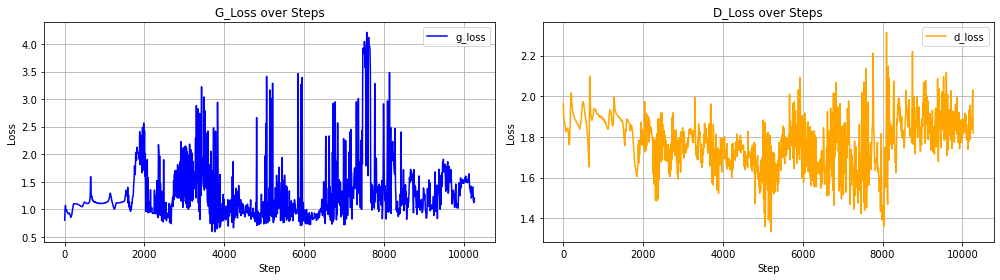

In [12]:
plt.figure(figsize=(14, 4))
# Plotting G_loss
plt.subplot(1, 2, 1)
plt.plot(g_loss['step'], g_loss['loss'], label='g_loss', color='blue')
plt.xlabel('Step')
plt.ylabel('Loss')
plt.title('G_Loss over Steps')
plt.legend()
plt.grid(True)

# Plotting D_loss
plt.subplot(1, 2, 2)
plt.plot(d_loss['step'], d_loss['loss'], label='d_loss', color='orange')
plt.xlabel('Step')
plt.ylabel('Loss')
plt.title('D_Loss over Steps')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

# Visualization (PCA/T-SNE)

In [13]:
current_day = '2020-05-01'
seq_length  = 14
cond_len = 5
seq_len = seq_length - cond_len
z_dim = 5
sample_size = 300

In [14]:
g_net = load_model(f'D:\CTS_GAN\models\g_models/{current_day}{name}', compile=False)
r_net = load_model(f'D:\CTS_GAN\models/r_models/{current_day}{name}',compile = False)
e_net = load_model(f'D:\CTS_GAN\models\e_models/{current_day}{name}',compile = False)
d_net = load_model(f'D:\CTS_GAN\models\d_models/{current_day}{name}',compile = False)
s_net = load_model(f'D:\CTS_GAN\models\s_models/{current_day}{name}',compile = False)

In [15]:
from tgan2 import *
DATA_DIR = 'D:\\CTS_GAN\\data'
def multi_stock_loading_first():

    data_dir = {'google': f"{DATA_DIR}/GOOG.csv", 'apple': f"{DATA_DIR}/AAPL.csv",
                'meta': f"{DATA_DIR}/META.csv", 'netflix': f"{DATA_DIR}/NFLX.csv",
                'amazon': f"{DATA_DIR}/AMZN.csv" }
    data = pd.read_csv(data_dir['meta'])
    data['Date'] = pd.to_datetime(data['Date'])

    for st, st_dir in data_dir.items():
        tmp = pd.read_csv(st_dir)
        tmp = tmp.rename(columns={'Adj Close': st})
        tmp['Date'] = pd.to_datetime(tmp['Date'])
        data = pd.merge(data, tmp[['Date', st]], on='Date', how='inner')
    #Only keep Adj Close column
    data.drop(columns=['Open', 'High', 'Low', 'Close', 'Adj Close', 'Volume'], inplace=True)

    return data

window_size = 2000
SEED = 3407 
set_random_seed(SEED)
data = multi_stock_loading_first()
start_day = 0

while start_day < len(data) - window_size:

    current_day = data.iloc[start_day + window_size]['Date'].strftime('%Y-%m-%d')
    print(current_day)
    tmp = data.iloc[start_day: start_day + window_size]
    data_v = tmp.drop(columns='Date').values
    if name == 'CTGAN_MA':
        tmp.set_index('Date', inplace=True)
        ma_20 = tmp.rolling(window=20).mean()
        result = (tmp - ma_20).dropna()
        data_v = result.values
    if name == 'CTGAN_F' or 'First' in name:
        print('111')
        tmp.set_index('Date', inplace=True)
        result = tmp.diff()
        result = result.dropna()
        data_v = result.values
    break

2020-05-01
111


In [16]:
data_v

array([[  0.34147 ,   0.936708,  -4.200001,   0.254285,   0.213   ],
       [ -0.331507,  -0.130653,  -3.029999,  -0.575714,  -0.139   ],
       [  0.215691,   0.411968,   1.      ,   0.6     ,   0.0975  ],
       ...,
       [ -2.110501,  -1.122062,  -4.589996, -17.550018,  -3.096001],
       [  5.390499,   2.236793,  11.279998,   8.060028,   2.931496],
       [  0.359002,   1.483857,  10.520005,   7.959991,   5.064499]])

In [17]:
scaler = MMS()
scaled_data = scaler.fit_transform(data_v).astype(np.float32)
data = []
for i in range(len(data_v) - seq_len):
    data.append(scaled_data[i:i + seq_len])

In [18]:
def make_random_data():
    while True:
        yield np.random.uniform(low=0, high=1, size=(seq_len, z_dim))

random_series = iter(tf.data.Dataset
                     .from_generator(make_random_data, output_types=tf.float32)
                     .batch(len(data), drop_remainder=True)
                     .repeat())
Z = next(random_series)

In [19]:
X = data
idx = np.random.permutation(len(X))[:sample_size]
real_sample = np.asarray(X)[idx,-seq_len:]

In [20]:
real_condition = np.asarray(X)[:,:cond_len]
#cz = tf.keras.layers.Concatenate(axis=1)([tf.convert_to_tensor(real_condition), Z])
c = Flatten()(real_condition)
c_pre = tf.tile(tf.expand_dims(c, axis=1), [1, tf.shape(Z)[1], 1])
cz = tf.concat([Z, c_pre], axis=-1)
E_hat = g_net(cz)[:, -seq_len: , :]
H_hat = s_net(E_hat)
X_hat = r_net(H_hat)

In [21]:
synthetic_sample = np.asarray(X_hat)[idx]

In [22]:
real_sample_2d = real_sample.reshape(-1, seq_len)
synthetic_sample_2d = synthetic_sample.reshape(-1, seq_len)
print(real_sample_2d.shape)
print(synthetic_sample_2d.shape)

(1500, 9)
(1500, 9)


In [23]:
pca = PCA(n_components=2)
pca.fit(real_sample_2d)
pca_real = (pd.DataFrame(pca.transform(real_sample_2d))
            .assign(Data='Real'))
pca_synthetic = (pd.DataFrame(pca.transform(synthetic_sample_2d))
                 .assign(Data='Synthetic'))
pca_result = pca_real.append(pca_synthetic).rename(
    columns={0: '1st Component', 1: '2nd Component'})

In [24]:
tsne_data = np.concatenate((real_sample_2d,
                            synthetic_sample_2d), axis=0)

tsne = TSNE(n_components=2,
            verbose=1,
            perplexity=40)
tsne_result = tsne.fit_transform(tsne_data)

[t-SNE] Computing 121 nearest neighbors...
[t-SNE] Indexed 3000 samples in 0.013s...
[t-SNE] Computed neighbors for 3000 samples in 0.222s...
[t-SNE] Computed conditional probabilities for sample 1000 / 3000
[t-SNE] Computed conditional probabilities for sample 2000 / 3000
[t-SNE] Computed conditional probabilities for sample 3000 / 3000
[t-SNE] Mean sigma: 0.035703
[t-SNE] KL divergence after 250 iterations with early exaggeration: 59.737019
[t-SNE] KL divergence after 1000 iterations: 0.742520


In [25]:
tsne_result = pd.DataFrame(tsne_result, columns=['X', 'Y']).assign(Data='Real')
tsne_result.loc[1500:, 'Data'] = 'Synthetic'

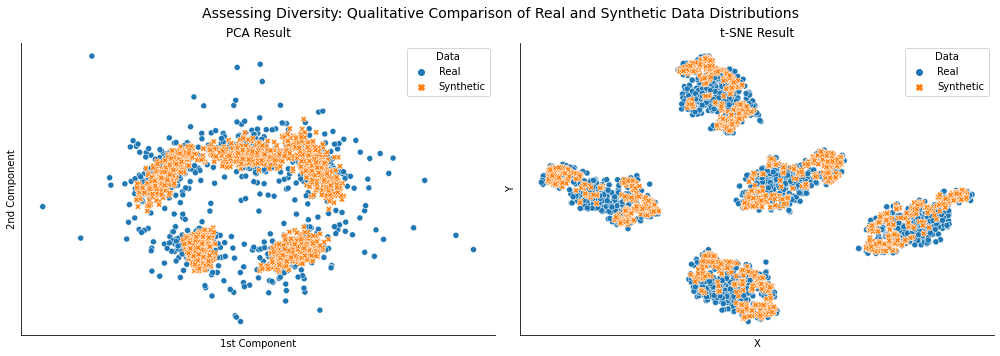

In [26]:
fig, axes = plt.subplots(ncols=2, figsize=(14, 5))

sns.scatterplot(x='1st Component', y='2nd Component', data=pca_result,
                hue='Data', style='Data', ax=axes[0])
sns.despine()
axes[0].set_title('PCA Result')


sns.scatterplot(x='X', y='Y',
                data=tsne_result,
                hue='Data', 
                style='Data', 
                ax=axes[1])
sns.despine()
for i in [0, 1]:
    axes[i].set_xticks([])
    axes[i].set_yticks([])

axes[1].set_title('t-SNE Result')
fig.suptitle('Assessing Diversity: Qualitative Comparison of Real and Synthetic Data Distributions', 
             fontsize=14)
fig.tight_layout()
fig.subplots_adjust(top=.88);

# Quantitative

Classification

In [27]:
n_data = len(data)
idx = np.arange(n_data)

In [28]:
n_train = int(0.8 * n_data)
train_idx = idx[:n_train]
test_idx = idx[n_train:]

In [29]:
train_data = np.vstack((np.array(X)[train_idx,-14:], 
                        np.array(X_hat)[train_idx]))
test_data = np.vstack((np.array(X)[test_idx, -14:], 
                       np.array(X_hat)[test_idx]))

In [30]:
n_train, n_test = len(train_idx), len(test_idx)
train_labels = np.concatenate((np.ones(n_train),
                               np.zeros(n_train)))
test_labels = np.concatenate((np.ones(n_test),
                              np.zeros(n_test)))

In [31]:
keras.utils.set_random_seed(4)

In [32]:
ts_classifier = Sequential([GRU(6, input_shape=(seq_len, 5), name='GRU'),
                            Dense(1, activation='sigmoid', name='OUT')],
                           name='Time_Series_Classifier')

In [33]:
ts_classifier.compile(loss='binary_crossentropy',
                      optimizer='adam',
                      metrics=[AUC(name='AUC'), 'accuracy'])

In [34]:
ts_classifier.summary()

Model: "Time_Series_Classifier"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 GRU (GRU)                   (None, 6)                 234       
                                                                 
 OUT (Dense)                 (None, 1)                 7         
                                                                 
Total params: 241 (964.00 Byte)
Trainable params: 241 (964.00 Byte)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [35]:
result = ts_classifier.fit(x=train_data,
                           y=train_labels,
                           validation_data=(test_data, test_labels),
                           epochs=150,
                           batch_size=64,
                           verbose=0)

In [36]:
ts_classifier.evaluate(x=test_data, y=test_labels)

25/25 [==============================] - 0s 3ms/step - loss: 1.2054 - AUC: 0.5338 - accuracy: 0.5389  


[1.2054264545440674, 0.5337617993354797, 0.5389447212219238]

In [37]:
history = pd.DataFrame(result.history)
history.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 150 entries, 0 to 149
Data columns (total 6 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   loss          150 non-null    float64
 1   AUC           150 non-null    float64
 2   accuracy      150 non-null    float64
 3   val_loss      150 non-null    float64
 4   val_AUC       150 non-null    float64
 5   val_accuracy  150 non-null    float64
dtypes: float64(6)
memory usage: 7.2 KB


In [49]:
history

,loss,AUC,accuracy,val_loss,val_AUC,val_accuracy
0,0.693683,0.506470,0.502827,0.693315,0.479903,0.435930
1,0.692777,0.518870,0.508166,0.693248,0.473277,0.585427
2,0.693127,0.508323,0.527010,0.693314,0.468934,0.594221
3,0.692901,0.510872,0.534234,0.693336,0.471696,0.467337
4,0.692786,0.518380,0.514447,0.693436,0.476052,0.346734
...,...,...,...,...,...,...
145,0.263718,0.953847,0.895729,1.178032,0.531278,0.550251
146,0.264562,0.953675,0.897613,1.183469,0.531688,0.547739
147,0.265099,0.953452,0.895415,1.208498,0.534355,0.537688
148,0.263244,0.953781,0.894158,1.230627,0.535684,0.523869


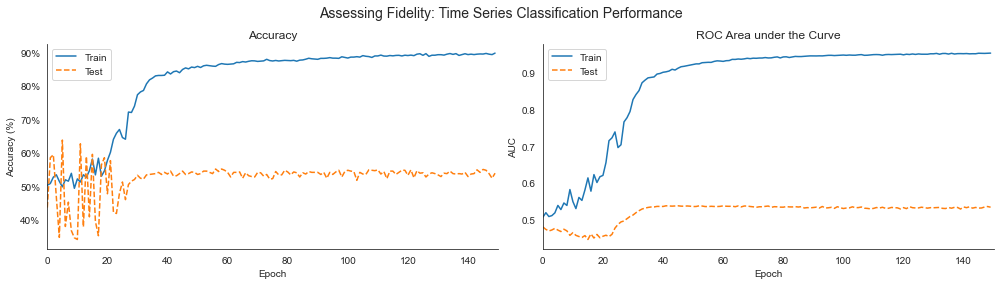

In [38]:
sns.set_style('white')
fig, axes = plt.subplots(ncols=2, figsize=(14,4))
history[['AUC', 'val_AUC']].rename(columns={'AUC': 'Train', 'val_AUC': 'Test'}).plot(ax=axes[1], 
                                                                                     title='ROC Area under the Curve',
                                                                                    style=['-', '--'],
                                                                                    xlim=(0, 150))
history[['accuracy', 'val_accuracy']].rename(columns={'accuracy': 'Train', 'val_accuracy': 'Test'}).plot(ax=axes[0], 
                                                                                                         title='Accuracy',
                                                                                                        style=['-', '--'],
                                                                                                        xlim=(0, 150))
for i in [0, 1]:
    axes[i].set_xlabel('Epoch')

axes[0].yaxis.set_major_formatter(FuncFormatter(lambda y, _: '{:.0%}'.format(y))) 
axes[0].set_ylabel('Accuracy (%)')
axes[1].set_ylabel('AUC')
sns.despine()
fig.suptitle('Assessing Fidelity: Time Series Classification Performance', fontsize=14)
fig.tight_layout()
fig.subplots_adjust(top=.85);

Prediction

In [39]:
real_data = np.array(X)[:,-seq_len:]
synthetic_data = np.array(X_hat)

In [40]:
real_data.shape, synthetic_data.shape

((1990, 9, 5), (1990, 9, 5))

In [41]:
real_train_data = real_data[train_idx, 1:seq_len-1, :]
real_train_label = real_data[train_idx, -1, :]

real_test_data = real_data[test_idx, 1:seq_len-1, :]
real_test_label = real_data[test_idx, -1, :]

In [42]:
synthetic_train = synthetic_data[:, 1:seq_len-1, :]
synthetic_label = synthetic_data[:, -1, :]

In [43]:
def get_model():
    model = Sequential([GRU(12, input_shape=(seq_len-2, 5)),
                        Dense(5)])

    model.compile(optimizer=Adam(),
                  loss=MeanAbsoluteError(name='MAE'))
    return model

In [44]:
ts_regression = get_model()
synthetic_result = ts_regression.fit(x=synthetic_train,
                                     y=synthetic_label,
                                     validation_data=(
                                         real_test_data, 
                                         real_test_label),
                                     epochs=150,
                                     batch_size=64,
                                     verbose=0)

In [45]:
ts_regression = get_model()
real_result = ts_regression.fit(x=real_train_data,
                                y=real_train_label,
                                validation_data=(
                                    real_test_data, 
                                    real_test_label),
                                epochs=150,
                                batch_size=64,
                                verbose=0)

In [46]:
synthetic_result = pd.DataFrame(synthetic_result.history).rename(columns={'loss': 'Train', 'val_loss': 'Test'})
synthetic_result

,Train,Test
0,0.301109,0.164703
1,0.083699,0.082357
2,0.052973,0.079073
3,0.051008,0.078131
4,0.050060,0.077350
...,...,...
145,0.038570,0.085054
146,0.038084,0.085195
147,0.038096,0.085382
148,0.038690,0.085775


In [47]:
real_result = pd.DataFrame(real_result.history).rename(columns={'loss': 'Train', 'val_loss': 'Test'})
real_result

,Train,Test
0,0.501674,0.421487
1,0.357892,0.326508
2,0.220994,0.164400
3,0.083115,0.082577
4,0.029433,0.079910
...,...,...
145,0.024245,0.075166
146,0.024474,0.075127
147,0.024232,0.075109
148,0.024225,0.075216


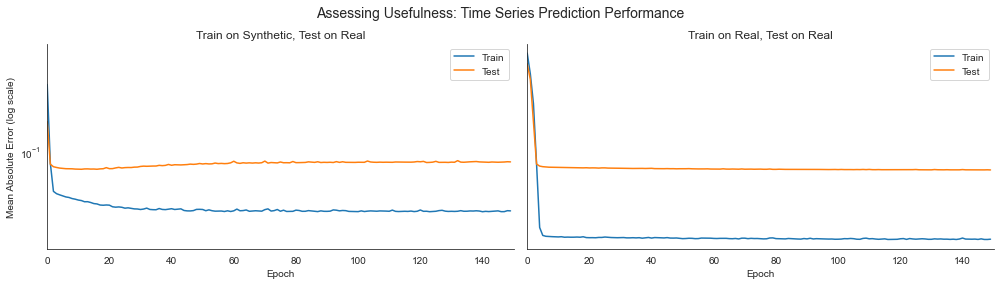

In [48]:
fig, axes = plt.subplots(ncols=2, figsize=(14, 4), sharey=True)
synthetic_result.plot(ax=axes[0], title='Train on Synthetic, Test on Real', logy=True, xlim=(0, 150))
real_result.plot(ax=axes[1], title='Train on Real, Test on Real', logy=True, xlim=(0, 150))
for i in [0, 1]:
    axes[i].set_xlabel('Epoch')
    axes[i].set_ylabel('Mean Absolute Error (log scale)')

sns.despine()
fig.suptitle('Assessing Usefulness: Time Series Prediction Performance', fontsize=14)
fig.tight_layout()
fig.subplots_adjust(top=.85);